In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import gensim
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Tweets.csv')
df.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
df.drop(['textID', 'selected_text'], inplace = True, axis = 1)
df.drop(df[df['sentiment'] == 'neutral'].index, inplace = True)

In [4]:
df['sentiment'].unique()

array(['negative', 'positive'], dtype=object)

In [5]:
df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [6]:
df.shape

(16363, 2)

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xMich\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = re.sub(r'[^a-z]', ' ', text)
    text = text.split()
    text = [token for token in text if token not in stop_words]
    return ' '.join(text)

In [9]:
df['text'] = df['text'].apply(preprocess_text)
df.head(5)

,text,sentiment
1,sooo sad miss san diego,negative
2,boss bullying,negative
3,interview leave alone,negative
4,sons put releases already bought,negative
6,feedings baby fun smiles coos,positive


In [10]:
df = df[df['text'].apply(lambda x: len(x) > 0)]
print(df.shape)

(16358, 2)


In [11]:
df['sentiment'].value_counts()

positive    8581
negative    7777
Name: sentiment, dtype: int64

In [12]:
df.drop(df[df['sentiment'] == 'negative'][7777:].index, inplace = True)
df.drop(df[df['sentiment'] == 'positive'][7777:].index, inplace = True)
df['sentiment'].value_counts()

negative    7777
positive    7777
Name: sentiment, dtype: int64

In [13]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True)

In [14]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xMich\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
def tokenize(text):
    return word_tokenize(text)

In [16]:
df['text'] = df['text'].apply(tokenize)
df.head(5)

,text,sentiment
1,"[sooo, sad, miss, san, diego]",negative
2,"[boss, bullying]",negative
3,"[interview, leave, alone]",negative
4,"[sons, put, releases, already, bought]",negative
6,"[feedings, baby, fun, smiles, coos]",positive


In [17]:
df['text'] = [[token for token in text if token in w2v.key_to_index] for text in df['text']]
df['text'] = [[w2v.key_to_index[token] for token in text] for text in df['text']]
df.head(5)

,text,sentiment
1,"[96190, 4067, 2116, 93622, 762521]",negative
2,"[3151, 10418]",negative
3,"[1152, 785, 1436]",negative
4,"[4420, 238, 5120, 311, 1741]",negative
6,"[98807, 2083, 1260, 10387, 132607]",positive


In [18]:
label_mapping = {'positive': 1, 'negative': 0}
df['sentiment'] = df['sentiment'].map(label_mapping)
df.head(5)

,text,sentiment
1,"[96190, 4067, 2116, 93622, 762521]",0
2,"[3151, 10418]",0
3,"[1152, 785, 1436]",0
4,"[4420, 238, 5120, 311, 1741]",0
6,"[98807, 2083, 1260, 10387, 132607]",1


In [19]:
def pad_seq(seq):
    if len(seq) < 10:
        seq.extend([0] * (10 - len(seq)))
    elif len(seq) > 10:
        seq = seq[:10]
    return seq

In [20]:
X = df['text']
y = df['sentiment']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)

In [22]:
class Dataset(Dataset):
    def __init__(self, X, y):
        self.X = [pad_seq(x) for x in X]
        self.y = np.array(y).reshape(-1, 1)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return torch.LongTensor(self.X[idx]), torch.Tensor(self.y[idx])

In [23]:
train_dataset = Dataset(X_train, y_train)
test_dataset = Dataset(X_test, y_test)
val_dataset = Dataset(X_val, y_val)

In [24]:
train_dl = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_dl = DataLoader(test_dataset, batch_size = 32, shuffle = True)
val_dl = DataLoader(val_dataset, batch_size = 32, shuffle = True)

In [25]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(w2v.vectors))
        self.lstm = nn.LSTM(input_size = 256, hidden_size = 8, batch_first = True)
        self.linear = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim = 1)
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        x = self.softmax(x)
        return x

In [26]:
model = Model()

In [27]:
def train_and_plot(train_dataloader, val_dataloader, model):
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 0.0001)
    num_epochs = 25
    train_loss_values, val_loss_values = [], []
    train_accuracy_values, val_accuracy_values = [], []
    for epoch in range(1, num_epochs + 1):
        model.train()
        total_train_loss = 0.0
        correct_train_predictions = 0
        total_train_samples = 0
        for x_train, y_train in train_dataloader:
            pred_train = model(x_train)
            y_train = y_train.squeeze(1).long()
            loss_train = loss_function(pred_train, y_train)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            total_train_loss += loss_train.item()
            correct_train_predictions += (torch.argmax(pred_train, dim = 1) == y_train).sum().item()
            total_train_samples += y_train.size(0)
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = correct_train_predictions / total_train_samples
        train_loss_values.append(avg_train_loss)
        train_accuracy_values.append(train_accuracy)
        model.eval()
        total_val_loss = 0.0
        correct_val_predictions = 0
        total_val_samples = 0
        with torch.no_grad():
            for x_val, y_val in val_dataloader:
                pred_val = model(x_val)
                y_val = y_val.squeeze(1).long()
                loss_val = loss_function(pred_val, y_val)
                total_val_loss += loss_val.item()
                correct_val_predictions += (torch.argmax(pred_val, dim = 1) == y_val).sum().item()
                total_val_samples += y_val.size(0)
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_accuracy = correct_val_predictions / total_val_samples
        val_loss_values.append(avg_val_loss)
        val_accuracy_values.append(val_accuracy)
        print(f'Epoch: {epoch} | Train Loss: {round(avg_train_loss, 4)} | Train Acc: {round(train_accuracy * 100, 2)}% | Val Loss: {round(avg_val_loss, 4)} | Val Acc: {round(val_accuracy * 100, 2)}%')
    plt.figure(figsize = (16, 9))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_values, label = 'Training Loss')
    plt.plot(val_loss_values, label = 'Validation Loss', linestyle = '--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_values, label = 'Training Accuracy', color = 'orange')
    plt.plot(val_accuracy_values, label = 'Validation Accuracy', color = 'red', linestyle = '--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

Epoch: 1 | Train Loss: 0.6966 | Train Acc: 49.98% | Val Loss: 0.6921 | Val Acc: 50.5%
Epoch: 2 | Train Loss: 0.689 | Train Acc: 51.52% | Val Loss: 0.6805 | Val Acc: 60.86%
Epoch: 3 | Train Loss: 0.6607 | Train Acc: 71.15% | Val Loss: 0.6302 | Val Acc: 74.5%
Epoch: 4 | Train Loss: 0.5932 | Train Acc: 78.19% | Val Loss: 0.5701 | Val Acc: 78.64%
Epoch: 5 | Train Loss: 0.5489 | Train Acc: 80.12% | Val Loss: 0.5461 | Val Acc: 78.57%
Epoch: 6 | Train Loss: 0.5285 | Train Acc: 80.72% | Val Loss: 0.5316 | Val Acc: 80.0%
Epoch: 7 | Train Loss: 0.5155 | Train Acc: 81.42% | Val Loss: 0.5212 | Val Acc: 80.07%
Epoch: 8 | Train Loss: 0.5049 | Train Acc: 81.93% | Val Loss: 0.5121 | Val Acc: 80.64%
Epoch: 9 | Train Loss: 0.4962 | Train Acc: 82.58% | Val Loss: 0.5051 | Val Acc: 81.43%
Epoch: 10 | Train Loss: 0.4887 | Train Acc: 83.28% | Val Loss: 0.4983 | Val Acc: 81.86%
Epoch: 11 | Train Loss: 0.4829 | Train Acc: 83.58% | Val Loss: 0.4928 | Val Acc: 82.79%
Epoch: 12 | Train Loss: 0.4777 | Train Acc: 8

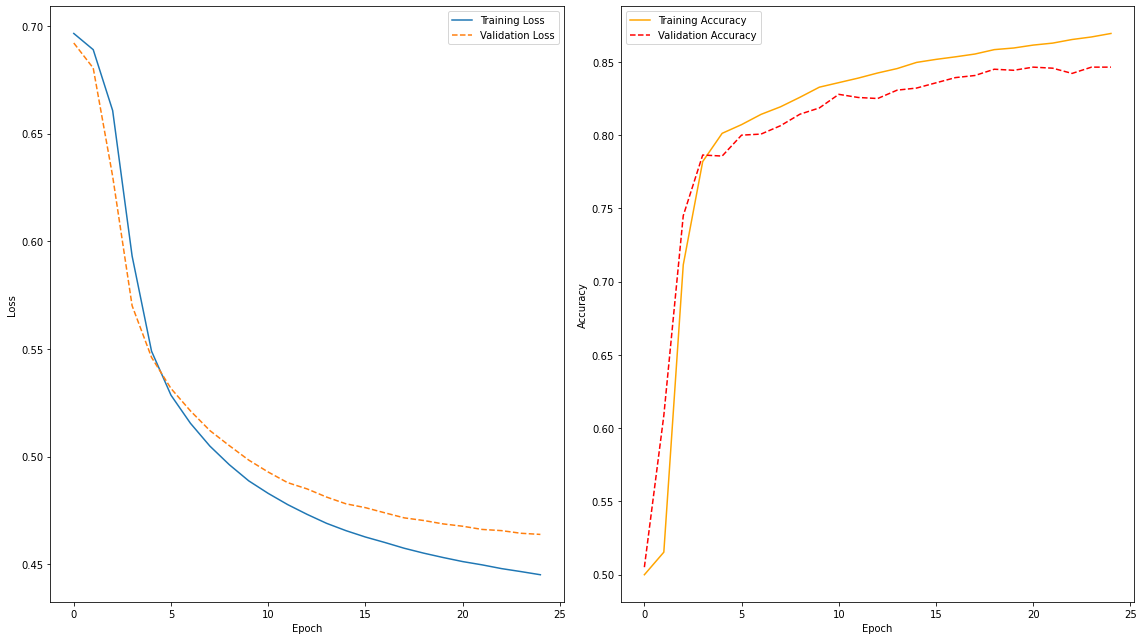

In [28]:
train_and_plot(train_dl, val_dl, model)

In [29]:
def compute_loss(model, dataloader):
    loss = nn.CrossEntropyLoss()
    total_loss = 0.0
    num_batches = len(dataloader)
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)
            y = y.squeeze(1).long()
            loss_value = loss(pred, y)
            total_loss += loss_value.item()
    avg_loss = total_loss / num_batches
    return avg_loss

In [30]:
test_loss = compute_loss(model, test_dl)
print(f'Test Loss: {round(test_loss, 2)}')

Test Loss: 0.47


In [31]:
def compute_accuracy(model, dataloader):
    correct_predictions = 0
    total_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)
            y = y.squeeze(1).long()
            _, pred = torch.max(pred, 1)
            correct_predictions += (pred == y).sum().item()
            total_samples += y.size(0)
    accuracy = correct_predictions / total_samples
    return accuracy

In [32]:
test_accuracy = compute_accuracy(model, test_dl)
print(f'Test Accuracy: {round(test_accuracy * 100, 2)}%')

Test Accuracy: 83.1%


In [33]:
def compute_confusion_matrix(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)
            y = y.squeeze(1).long()
            _, pred = torch.max(pred, 1)       
            all_labels.extend(y.numpy())
            all_predictions.extend(pred.numpy())
    cm = confusion_matrix(all_labels, all_predictions)
    return cm

In [34]:
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize = (8, 8))
    sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

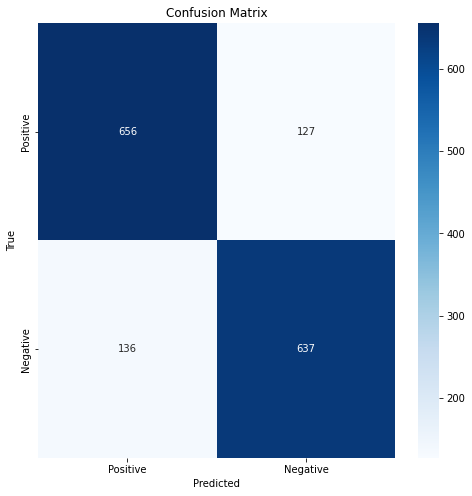

In [35]:
conf_matrix = compute_confusion_matrix(model, test_dl)
plot_confusion_matrix(conf_matrix, ['Positive', 'Negative'])